In [42]:
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Flatten, Reshape, Dropout
from keras.layers.convolutional import Conv2D, UpSampling2D,Cropping2D,ZeroPadding2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, MaxPool2D
from keras.layers.merge import Concatenate, Add
from keras.layers import Input
from keras import optimizers
from keras import losses
from keras import metrics
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import LSTM
from keras import regularizers
import keras.backend as K
import keras

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

from keras.utils import plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from pathlib import Path
import numpy as np
import h5py
import cv2
import datetime
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss



In [2]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

In [3]:
HDF5_PATH = "./Data_10sec.hdf5"

hdf = h5py.File(HDF5_PATH, "r")
pframes = hdf[ "Validation_Set/Total_Video"]
plt.imshow(pframes[44], interpolation='nearest')
plt.show()

In [5]:
#to get the total samples in each set
train_len = len(hdf["Training_Set/Total_Gaze"])
test_len = len(hdf["Testing_Set/Total_Gaze"])
val_len = len(hdf["Validation_Set/Total_Gaze"])


In [7]:
def myGenerator(set_name,batch_size,timesteps):
    
    hdf = h5py.File(HDF5_PATH, "r")
    
    pgaze = hdf[set_name +"/Total_Gaze"][:,:,1:3]
    pframes = hdf[set_name +"/Total_Video"]
    pLabels = hdf[set_name +"/Total_Label"][:,1:10]

    len_train = pgaze.shape[0]
    randomBatchOrder = list(range(len_train-timesteps))
    while True:
        #np.random.shuffle(randomBatchOrder) 
        for i in range(0, (len_train // (batch_size))-1):
            gaze = []
            frames = []
            labels = []
            for j in range (batch_size): # this loop fetches batch_size number of samples, each sample having timestep samples
                idx = randomBatchOrder[i*batch_size+j]
                
                g = pgaze[idx:idx+timesteps]
                gaze.append(g)
                f = pframes[idx:idx+timesteps]
                frames.append(f)
                l = pLabels[idx+timesteps]
                labels.append(l)

            yield [np.array(gaze).reshape(batch_size, -1, 2,1), np.array(frames)], np.array(labels)
            

In [26]:
#hyperparameters
timesteps = 60//5
batch_size = 15
epochs = 150
NUM_CLASSES =9
g = myGenerator('Training_Set', batch_size, timesteps)

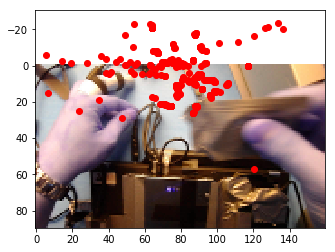

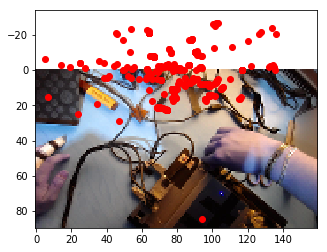

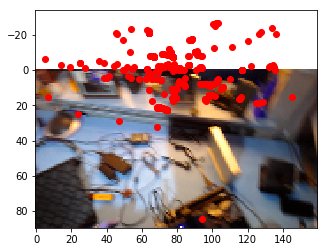

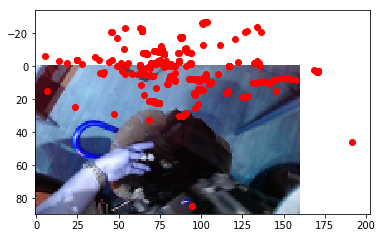

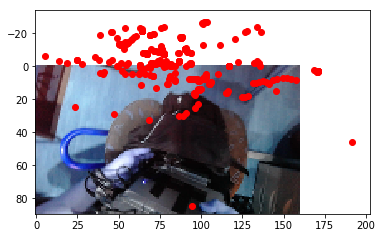

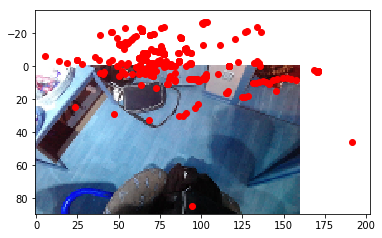

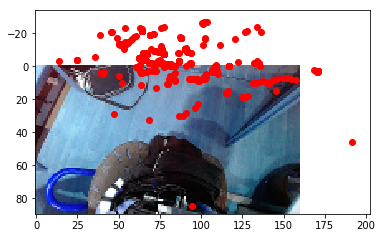

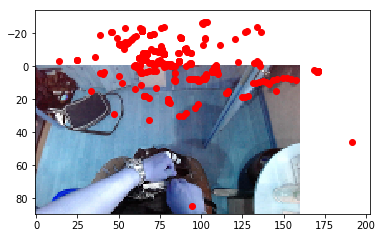

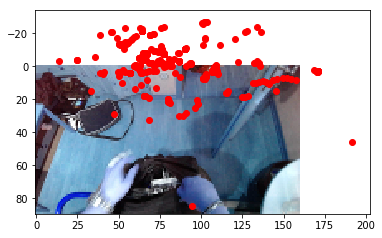

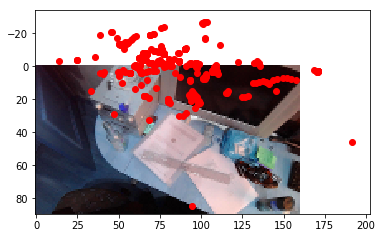

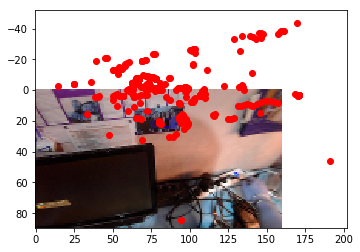

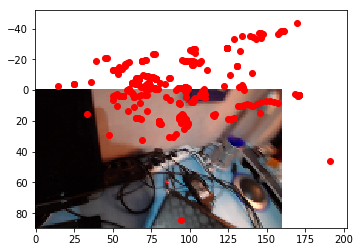

In [28]:
x,y  = next(g)
i = 3
for idx in range(timesteps):
    img = x[1][i][idx]
    plt.imshow(img)
    gaze = x[0][idx]
    plt.scatter(gaze[:,0]*img.shape[1], gaze[:,1]*img.shape[0], c="r")
    plt.show()

In [30]:
gazeShape = x[0].shape
imgShape = x[1].shape

print(y.shape,gazeShape,imgShape)

(15, 360, 2, 1)

# Model

In [32]:
with tf.device('/device:GPU:0'):
    config = tf.ConfigProto(log_device_placement = True, allow_soft_placement = True)
    config.gpu_options.allow_growth=True
    config.gpu_options.per_process_gpu_memory_fraction = 0.7
    config.gpu_options.allocator_type = 'BFC'
    
    with tf.Session(config=config):
        tf.get_default_graph()
        
        # Broadcast progress to the tensorboard.
        readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
        file_name = "Team3_" + readable_timestamp
        print(file_name)
        tensorboardFolder = "/srv/share/tensorboardfiles/" + file_name
        
        
        optimizer=optimizers.Adam(lr = 0.0001)
                
        cnn_base = VGG19(input_shape=(imgShape[2], imgShape[3], imgShape[4]), weights="imagenet", include_top=False)
        cnn_out = GlobalAveragePooling2D()(cnn_base.output)
        cnn = Model(inputs=cnn_base.input, outputs=cnn_out) #VGG19 pretrained model
        for layer in cnn.layers: 
            layer.trainable = False   
            
        scene_input = Input(shape=(timesteps,imgShape[2], imgShape[3], imgShape[4]), name='scene_input')
        scene_frames = TimeDistributed(cnn)(scene_input) #Timedistributed wrapper around VGG19 model
        scene_flatten_TD = TimeDistributed(Flatten())(scene_frames)
        scene_flatten = LSTM(50, dropout=0.7, recurrent_dropout=0.7)(scene_flatten_TD)
        
        gaze_input = Input(shape = (gazeShape[1], gazeShape[2],gazeShape[3]),name = "gaze_input") #reshaped gaze input
        gaze_Conv2D_1 = Conv2D(filters = 64, kernel_size = (4,1), activation ='relu',
                               kernel_initializer= 'glorot_normal')(gaze_input)
        gaze_Maxpool = MaxPool2D(pool_size=(10,1))(gaze_Conv2D_1)
       
        gaze_Conv2D_2 = Conv2D(filters = 32, kernel_size = (4,1), activation ='relu',
                               kernel_initializer= 'glorot_normal')(gaze_Maxpool)
        gaze_Maxpool2 = MaxPool2D(pool_size=(10,1))(gaze_Conv2D_2)
        
        gaze_flatten = Flatten()(gaze_Maxpool2)
        Merge = Concatenate()([gaze_flatten, scene_flatten]) # concatenate intermediate outputs from gaze and scene model

        Dense1 = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01))(Merge)
        Dense1 = Dropout(0.3)(Dense1)
        Dense2 = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01))(Dense1)
        Dense2 = Dropout(0.3)(Dense2)
        Out = Dense(NUM_CLASSES, activation='sigmoid')(Dense2) # final output layer
            
            # Multi-task loss
        def multitask_loss(y_true, y_pred):
            # Avoid divide by 0
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))
        
       
        Combined_model = Model(inputs=[gaze_input, scene_input], outputs=[Out])
        Combined_model.compile(optimizer=optimizer, loss=multitask_loss, metrics = [multitask_loss, "acc"])
        Combined_model.summary()
        
        callbacks = [
            ModelCheckpoint(str(Path.home()) + "/models/"+ file_name + ".{epoch:04d}-{val_loss:.2f}.h5",
                            monitor='val_acc',
                            verbose=0,
                            save_best_only=True,
                            save_weights_only=False
                           ),
            LoggingTensorBoard(settings_str_to_log=config,
                               log_dir=tensorboardFolder,
                               histogram_freq=0,
                               write_graph=True,
                               write_images=True,
                               update_freq='epoch'
                              ),
            # Learning Rate
            ReduceLROnPlateau(monitor='val_loss',
                              patience=10,
                              verbose=1,
                              factor=0.9,
                              min_lr=0.00001),
        ]

        history = Combined_model.fit_generator(myGenerator("Training_Set",batch_size,timesteps),
                                steps_per_epoch=train_len // batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data= myGenerator("Testing_Set",batch_size,timesteps),
                                validation_steps=test_len // batch_size,
                                callbacks = callbacks)
        
        result = Combined_model.predict_generator(myGenerator("Validation_Set",batch_size,timesteps),
                                                steps=val_len // batch_size)

Team3_20190204_145106
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gaze_input (InputLayer)         (None, 360, 2, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 357, 2, 64)   320         gaze_input[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 35, 2, 64)    0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
scene_input (InputLayer)        (None, 12, 90, 160,  0                                            
_______________________________________________________________________________________

Epoch 24/150
1514/1514 [==============================] - 450s 297ms/step - loss: 2.5912 - multitask_loss: 2.4212 - acc: 0.4678 - val_loss: 3.6853 - val_multitask_loss: 3.5172 - val_acc: 0.2934
Epoch 25/150
1514/1514 [==============================] - 449s 297ms/step - loss: 2.5727 - multitask_loss: 2.4025 - acc: 0.4687 - val_loss: 3.6574 - val_multitask_loss: 3.4883 - val_acc: 0.2968
Epoch 26/150
1514/1514 [==============================] - 444s 293ms/step - loss: 2.5570 - multitask_loss: 2.3875 - acc: 0.4694 - val_loss: 3.6537 - val_multitask_loss: 3.4858 - val_acc: 0.2973
Epoch 27/150
1514/1514 [==============================] - 442s 292ms/step - loss: 2.5331 - multitask_loss: 2.3646 - acc: 0.4723 - val_loss: 3.6398 - val_multitask_loss: 3.4731 - val_acc: 0.2928
Epoch 28/150
1514/1514 [==============================] - 441s 291ms/step - loss: 2.5197 - multitask_loss: 2.3520 - acc: 0.4732 - val_loss: 3.6762 - val_multitask_loss: 3.5096 - val_acc: 0.2942
Epoch 30/150
1514/1514 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1514/1514 [==============================] - 443s 293ms/step - loss: 2.2900 - multitask_loss: 2.1283 - acc: 0.4950 - val_loss: 3.6434 - val_multitask_loss: 3.4814 - val_acc: 0.2826
Epoch 52/150
1514/1514 [==============================] - 442s 292ms/step - loss: 2.2835 - multitask_loss: 2.1229 - acc: 0.4964 - val_loss: 3.6120 - val_multitask_loss: 3.4507 - val_acc: 0.2853
Epoch 53/150
1514/1514 [==============================] - 442s 292ms/step - loss: 2.2733 - multitask_loss: 2.1134 - acc: 0.4954 - val_loss: 3.6039 - val_multitask_loss: 3.4421 - val_acc: 0.2888
Epoch 54/150
1514/1514 [==============================] - 440s 291ms/step - loss: 2.2672 - multitask_loss: 2.1065 - acc: 0.4976 - val_loss: 3.5868 - val_multitask_loss: 3.4247 - val_acc: 0.2862
Epoch 55/150
1514/1514 [==============================] - 440s 291ms/step - loss: 2.2550 - multitask_loss: 2.0946 - acc: 0.5012 - val_loss: 3.6459 - val_multitask_loss: 3.4841 - val_acc: 0.2866
Epoch 56/150
1514/1514 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1514/1514 [==============================] - 440s 291ms/step - loss: 2.1986 - multitask_loss: 2.0401 - acc: 0.5061 - val_loss: 3.6199 - val_multitask_loss: 3.4594 - val_acc: 0.2959

Epoch 00064: ReduceLROnPlateau reducing learning rate to 8.100000122794882e-05.
Epoch 65/150
1514/1514 [==============================] - 440s 291ms/step - loss: 2.1772 - multitask_loss: 2.0197 - acc: 0.5089 - val_loss: 3.6399 - val_multitask_loss: 3.4799 - val_acc: 0.3002
Epoch 70/150
1514/1514 [==============================] - 441s 291ms/step - loss: 2.1686 - multitask_loss: 2.0113 - acc: 0.5049 - val_loss: 3.5864 - val_multitask_loss: 3.4268 - val_acc: 0.2990
Epoch 71/150
1514/1514 [==============================] - 440s 291ms/step - loss: 2.1624 - multitask_loss: 2.0056 - acc: 0.5098 - val_loss: 3.6377 - val_multitask_loss: 3.4790 - val_acc: 0.2996
Epoch 72/150
1514/1514 [==============================] - 440s 291ms/step - loss: 2.1522 - multitask_loss: 1.9957 - acc: 0.5105 - val_loss: 3.6276 - val_mul

1514/1514 [==============================] - 441s 291ms/step - loss: 1.8570 - multitask_loss: 1.6948 - acc: 0.5401 - val_loss: 3.7090 - val_multitask_loss: 3.5449 - val_acc: 0.3153
Epoch 149/150
1514/1514 [==============================] - 441s 291ms/step - loss: 1.8496 - multitask_loss: 1.6873 - acc: 0.5427 - val_loss: 3.6918 - val_multitask_loss: 3.5276 - val_acc: 0.3162
Epoch 150/150
1514/1514 [==============================] - 442s 292ms/step - loss: 1.8477 - multitask_loss: 1.6856 - acc: 0.5370 - val_loss: 3.6724 - val_multitask_loss: 3.5082 - val_acc: 0.3144

Epoch 00150: ReduceLROnPlateau reducing learning rate to 3.4867842987296176e-05.


# Results

In [70]:
#Ground truth labels of validation set
val_label = hdf["Validation_Set/Total_Label"][4:2974,1:10]
print(val_label.shape)

#Convert the probabilities to predicted label vectors
result[result>=0.5] =1
result[result<0.5] =0
print(hamming_loss(val_label,result))


0.2328843995510662


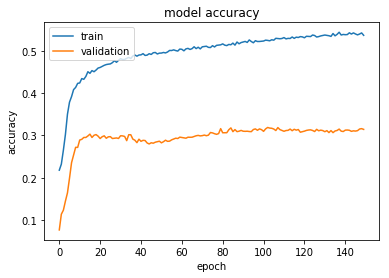

In [40]:
#summarize history for loss
plt.plot(history.history['multitask_loss'])
plt.plot(history.history['val_multitask_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [43]:
#Confusion matrix of each activity
for activity in range(10):
    print("Activity ",activity+1,confusion_matrix(val_label[:,activity], result[:,activity]))
    

Activity 1
[[2441    1]
 [ 491   37]]
Activity 2
[[1962  180]
 [ 364  464]]
Activity 3
[[1815  462]
 [ 380  313]]
Activity 4
[[2225  237]
 [ 365  143]]
Activity 5
[[1616  510]
 [ 411  433]]
Activity 6
[[1520  514]
 [ 565  371]]
Activity 7
[[2486  213]
 [ 230   41]]
Activity 8
[[2569   17]
 [ 245  139]]
Activity 9
[[1496  157]
 [1102  215]]


In [44]:
#Confusion matrix in percentage
for val in range(10):
    print("Activity", val+1) 
    confusion_mat = confusion_matrix(val_label[:,val], result[:,val])
    mat_toarray = np.asarray(confusion_mat)
    array_sum = np.sum(mat_toarray)
    print((mat_toarray/array_sum)*100)

Activity 1
[[8.21885522e+01 3.36700337e-02]
 [1.65319865e+01 1.24579125e+00]]
Activity 2
[[66.06060606  6.06060606]
 [12.25589226 15.62289562]]
Activity 3
[[61.11111111 15.55555556]
 [12.79461279 10.53872054]]
Activity 4
[[74.91582492  7.97979798]
 [12.28956229  4.81481481]]
Activity 5
[[54.41077441 17.17171717]
 [13.83838384 14.57912458]]
Activity 6
[[51.17845118 17.30639731]
 [19.02356902 12.49158249]]
Activity 7
[[83.7037037   7.17171717]
 [ 7.74410774  1.38047138]]
Activity 8
[[86.4983165   0.57239057]
 [ 8.24915825  4.68013468]]
Activity 9
[[50.37037037  5.28619529]
 [37.1043771   7.23905724]]
